## Introduction


これは、Mercari Price Suggestion Challenge に対する初期の探索的データ分析（Explanatory Data Analysis）です。
matplotlib、bokeh、そして Plot.ly を使用しています。Plot.ly は、美しいインタラクティブなプロットやダッシュボードを作成できる可視化ツールです。
このコンペティションは、Mercari（メルカリ）が主催しています。メルカリは日本最大のコミュニティ主導型ショッピングアプリであり、目的は、出品された商品の情報をもとに、メルカリが出品者に提案すべき適切な価格を予測することです。



In [1]:
# nltk:自然言語処理用のライブラリ
import nltk
import string
import re
import numpy as np
import pandas as pd
import pickle
#import lda

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import _stop_words
sns.set(style="white")

from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
%matplotlib inline


## EDA

データを最初に確認したところ、一意の識別子（`item_id`）を除いて、このモデルには7つの変数が含まれています。  
このノートブックでは、それらの各変数について簡単な統計的概要を順に見ていきます。

### 1. 数値／連続値の特徴量（Numerical/Continuous Features）

**A. price**  
商品の最終入札価格。これはテストセットで予測すべき目的変数（従属変数）になります。

**B. shipping cost**  
送料の金額。


### 2. カテゴリ特徴量（Categorical Features）

**A. shipping cost**  
バイナリ指標。出品者が送料を負担する場合は `1`、購入者が負担する場合は `0`。

**B. item_condition_id**  
出品者が提供する商品の状態。

**C. name**  
商品の名前。

**D. brand_name**  
商品のブランド名（製造元のブランド名）。

**E. category_name**  
商品のカテゴリ（単一または複数）。カテゴリは `¥` で区切られていることがある。

**F. item_description**  
商品の説明文。一部の単語が削除されていたり、`[rm]` でフラグされている可能性がある。

In [2]:
train = pd.read_csv('./data/train.tsv', sep='\t')
test = pd.read_csv('./data/test.tsv', sep='\t')

In [3]:
# size of training and dataset
print(train.shape)
print(test.shape)

(1482535, 8)
(693359, 7)


In [4]:
for dx,col in enumerate(train.columns):
    print(f"{dx+1}.{col} : {train[col].dtype}")

1.train_id : int64
2.name : object
3.item_condition_id : int64
4.category_name : object
5.brand_name : object
6.price : float64
7.shipping : int64
8.item_description : object


In [5]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


### Target Variable:Privce

次の標準的な確認項目は、目的変数（response または target variable）です。  
この場合、`price`（価格）が対象であり、これはメルカリのマーケットプレイス出品者に提案する価格となります。

トレーニングデータに含まれる商品の**中央値価格は約￥267**ですが、  
**￥100を超える極端な値や、最大で￥2,009という値が存在する**ため、  
この変数の分布は**大きく左に歪んでいます（正の歪み）**。

そのため、`price` に対して**対数変換（log-transformation）**を行います。  
（ゼロや負の値を避けるため、変換前に +1 を加えています）


In [6]:
train.price.describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

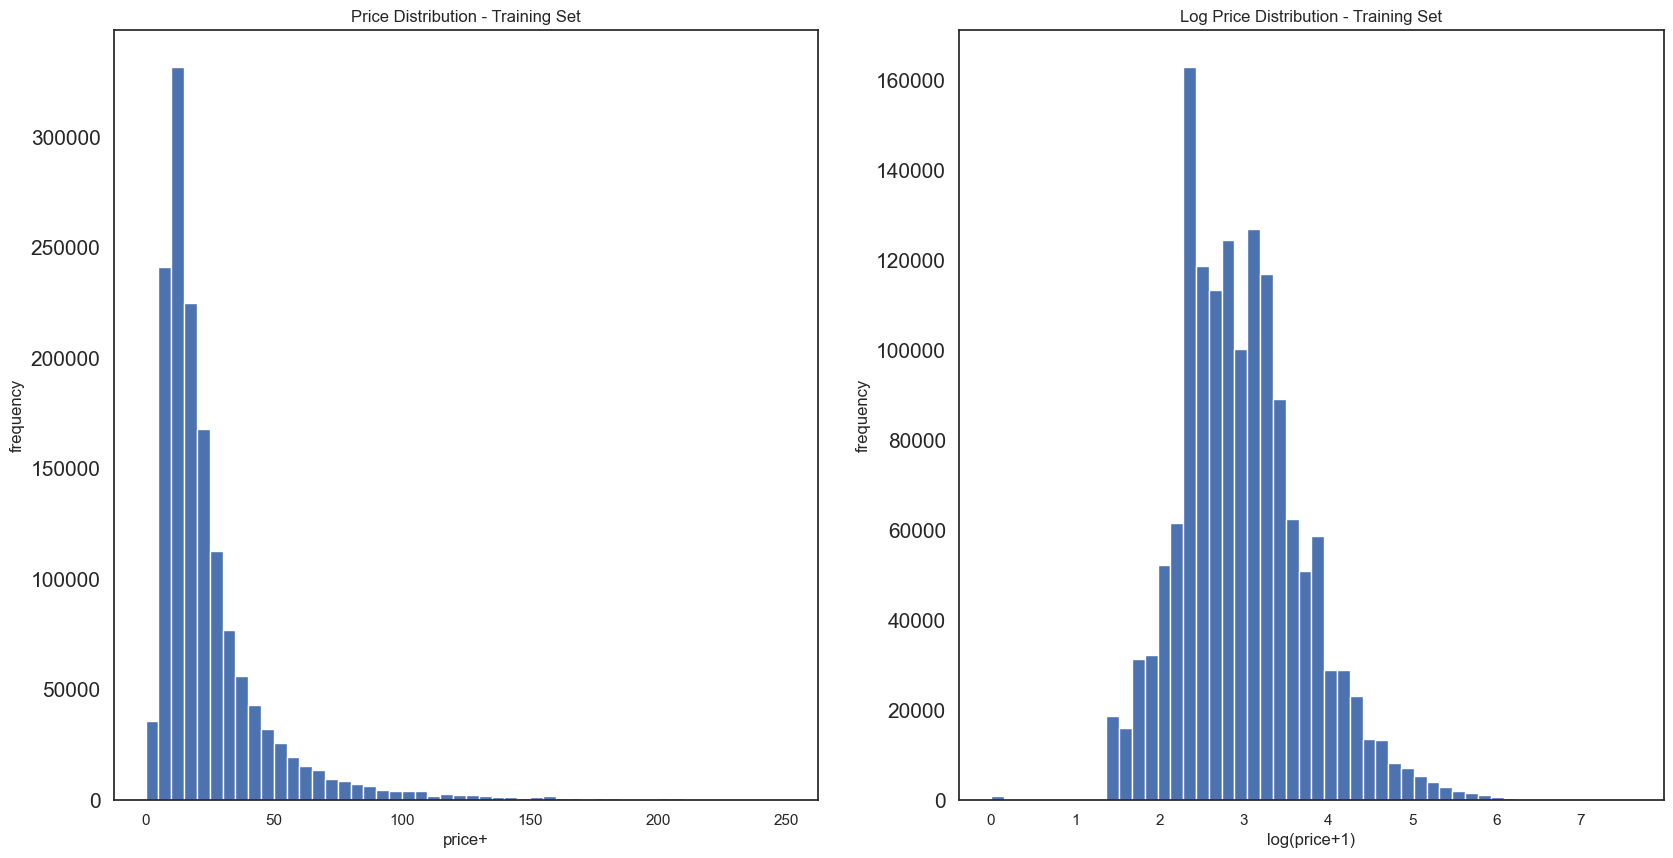

In [7]:
f,ax=plt.subplots(1,2,figsize=(18,8))
(train['price']).plot.hist(bins=50, figsize=(20,10), edgecolor='white',range=[0,250],ax=ax[0])
ax[0].set_xlabel('price+')
ax[0].set_ylabel('frequency')
ax[0].tick_params(axis='y', labelsize=15)
ax[0].set_title('Price Distribution - Training Set', )
np.log(train['price']+1).plot.hist(bins=50, figsize=(20,10), edgecolor='white',ax=ax[1])
ax[1].set_xlabel('log(price+1)')
ax[1].set_ylabel('frequency')
ax[1].tick_params(axis='y', labelsize=15)
ax[1].set_title('Log Price Distribution - Training Set' )
plt.show()

### Shipping

送料の負担は出品者と購入者の間で適度に分担されており、商品の送料の半数以上（55%）は出品者が負担しています。
さらに、送料を負担しなければならないユーザーが支払う平均価格は、送料が不要なユーザーよりも低くなっています。
これは、「出品者は追加の送料分を補うために、商品価格を安く設定する必要がある」という私たちの認識と一致しています。

In [8]:
train.shipping.value_counts()/len(train)

shipping
0    0.552726
1    0.447274
Name: count, dtype: float64

In [9]:
prc_shipBySeller = train.loc[train.shipping == 1, 'price']

- train データフレームから、shipping 列の値が 1 の行を抽出します。

- .loc[条件, 'price']：条件を満たす行の price 列の値だけを取り出します。

- prc_shipBySeller：出品者が送料を負担した商品の価格のリストになります。



In [13]:
prc_shipByBuyer = train.loc[train.shipping == 0, 'price']

- shipping == 0：購入者（buyer）が送料を負担していることを意味します。

- 同様に、そのときの price（価格）だけを抽出しています。

- prc_shipByBuyer：購入者が送料を負担した商品の価格のリストになります。



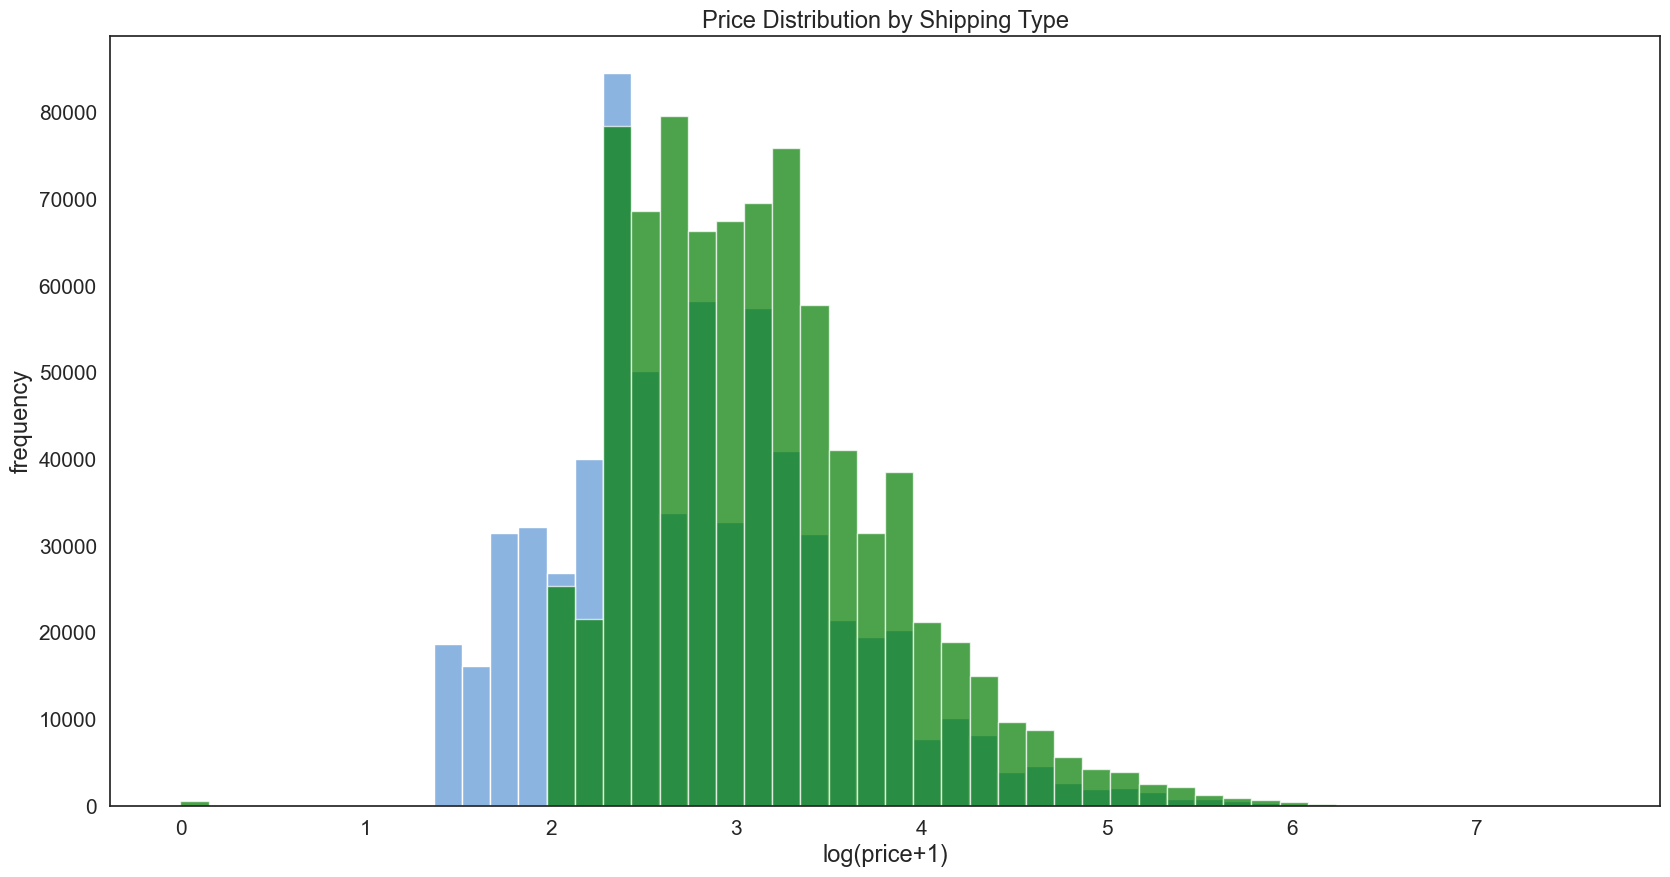

In [14]:
fig, ax = plt.subplots(figsize=(20,10))
ax.hist(np.log(prc_shipBySeller+1), color='#8CB4E1', alpha=1.0, bins=50,
       label='Price when Seller pays Shipping')
ax.hist(np.log(prc_shipByBuyer+1), color='#007D00', alpha=0.7, bins=50,
       label='Price when Buyer pays Shipping')
ax.set(title='Histogram Comparison', ylabel='% of Dataset in Bin')
plt.xlabel('log(price+1)', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.title('Price Distribution by Shipping Type', fontsize=17)
plt.tick_params(labelsize=15)
plt.show()
